<a href="https://colab.research.google.com/github/SenolIsci/Credit_Risk_Assessment_ML/blob/main/Credit_Risk_Assesment_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CREDIT RISK ASSESSMENT USING ML

### Part 1 DATA AND MODEL
Some data wrangling

[optional] Some outlier removal based on domain knowledge

Use Column Transformer and Pipeline to streamline process

Use Randomized Search to find optimal set of parameters

Automate the procedure for multiple classifiers

Plot Precision-Recall Curve

Plot Learning Curve (for bias-variance tradeoff / check for overfitting-underfitting) 


### Part 2 OPTIMIZATION
Rectify existing model based on inferences from the learning curve and make a better one

### Part 3 EXPLAINABLE AI USING SHAP

### Part 4 DECILE ANALYSIS FOR CREDIT RISK SCORING


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,OrdinalEncoder,StandardScaler,RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

In [2]:
!pip install shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if 0:
 dir_path="/content/drive/My Drive/Project1_Credit_Scoring/"
 file_name="a_Dataset_CreditScoring.xlsx"
 df = pd.read_excel(dir_path+file_name)
 TARGET_COL='TARGET'
 df.head()
if 1:
  dir_path='/content/drive/My Drive/Credit_Scoring_MLprojects_main/credit_risk/'
  file_name='credit_risk_dataset.csv'
  df = pd.read_csv(dir_path+file_name)
  TARGET_COL='loan_status'
  df.head()

In [5]:
dups = df.duplicated()

In [6]:
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [7]:
df.shape

(32581, 12)

In [8]:
#remove dublicate
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(32416, 12)

In [10]:
#dropping customer ID column from the dataset
df=df.drop('ID',axis=1,errors='ignore')

In [11]:
#dropping NaN values
#df=df.dropna()

In [12]:
# X and y will be thought of as the entire training data
# X_test and y_test will be thought of as the out of sample data for model evaluation

X, X_test, y, y_test = train_test_split(df.drop(TARGET_COL, axis=1), df[TARGET_COL],
                                        random_state=0,  test_size=0.2, stratify=df[TARGET_COL],
                                        shuffle=True)

In [13]:
df[TARGET_COL].value_counts(normalize=True)

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

In [14]:
y.value_counts(normalize=True)

0    0.781313
1    0.218687
Name: loan_status, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.781308
1    0.218692
Name: loan_status, dtype: float64

In [16]:
np.round(X.isna().sum()* 100 / X.shape[0], 3)

person_age                    0.000
person_income                 0.000
person_home_ownership         0.000
person_emp_length             2.800
loan_intent                   0.000
loan_grade                    0.000
loan_amnt                     0.000
loan_int_rate                 9.614
loan_percent_income           0.000
cb_person_default_on_file     0.000
cb_person_cred_hist_length    0.000
dtype: float64

In [17]:
X.shape

(25932, 11)

In [18]:
X.dropna().shape

(22763, 11)

In [19]:
for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<10:
        print(X[col].value_counts(normalize=True)*100)
    print()

person_age ---> 58

person_income ---> 3680

person_home_ownership ---> 4
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: person_home_ownership, dtype: float64

person_emp_length ---> 36

loan_intent ---> 6
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: loan_intent, dtype: float64

loan_grade ---> 7
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: loan_grade, dtype: float64

loan_amnt ---> 710

loan_int_rate ---> 346

loan_percent_income ---> 75

cb_person_default_on_file ---> 2
N    82.392411
Y    17.607589
Name: cb_person_default_on_file, dtype: float64

cb_person_cred_hist_length ---> 29



In [20]:
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,25932.000000,2.593200e+04,25206.000000,25932.000000,23439.000000,25932.000000,25932.000000
mean,27.721155,6.589884e+04,4.811315,9611.395187,11.013784,0.170733,5.793460
std,6.382311,6.333831e+04,4.172822,6339.054572,3.240104,0.106879,4.052297
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.849500e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.900000e+04,7.000000,12250.000000,13.480000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [21]:
# # count of good loans (0) and bad loans (1)
df[TARGET_COL].value_counts()

0    25327
1     7089
Name: loan_status, dtype: int64

In [22]:
# # data summary across 0 & 1
df.groupby(TARGET_COL).mean()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
loan_status,,,,,,,
0,27.823311,70849.122794,4.970673,9240.155763,10.439218,0.148794,5.846725
1,27.474397,49094.497955,4.136310,10857.479898,13.067773,0.246906,5.684723


In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25932 entries, 21415 to 6848
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  25932 non-null  int64  
 1   person_income               25932 non-null  int64  
 2   person_home_ownership       25932 non-null  object 
 3   person_emp_length           25206 non-null  float64
 4   loan_intent                 25932 non-null  object 
 5   loan_grade                  25932 non-null  object 
 6   loan_amnt                   25932 non-null  int64  
 7   loan_int_rate               23439 non-null  float64
 8   loan_percent_income         25932 non-null  float64
 9   cb_person_default_on_file   25932 non-null  object 
 10  cb_person_cred_hist_length  25932 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 2.4+ MB


In [24]:
[col for col in X]

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [25]:
num_cols = [col for col in X if X[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

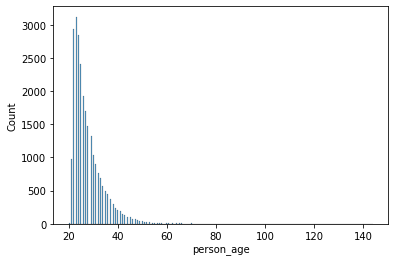

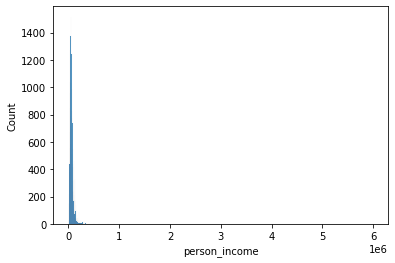

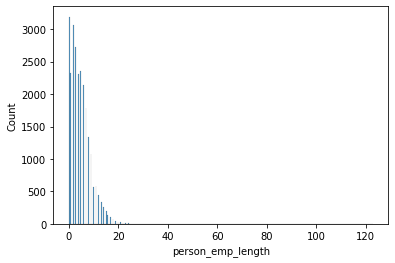

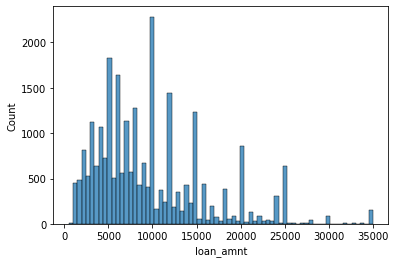

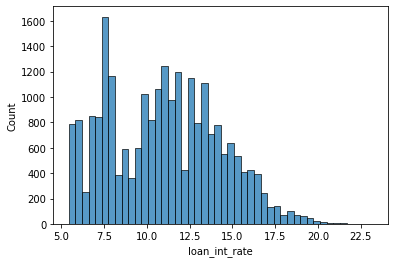

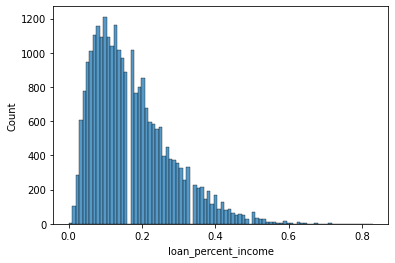

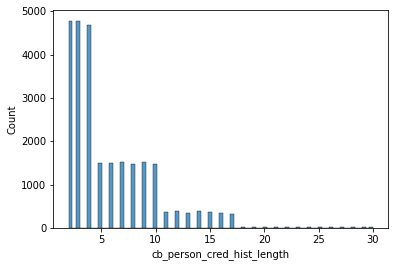

In [26]:
for col in num_cols:
    sns.histplot(X[col])
    plt.show()

Some feature distributions are highly skewed. Therefore, a log transformation can help it to make similar to a normal/gaussian distribution as some model prediction algorithms assume features with normal distribution.

Also there are some outliers in the features such as person_age. Using a scaler robust to outliers may help.

Data has missing values. Missing data entries can be removed but this removes a lot of data sample. Alternatively, an imputation method can be used.

In [27]:
# since/ if we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

In [28]:
cat_cols = [col for col in X if X[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [29]:
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('logtrans',FunctionTransformer(np.log1p)),
    ('scale', RobustScaler()),
])

In [30]:
ct = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    #('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
    ('cat_cols', OrdinalEncoder(), cat_cols)

], remainder='passthrough')

In [31]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1):
    {'model__n_estimators':[100,200,300,500],
     'model__max_depth':[5, 9,13],
     'model__min_samples_split':[4,6,8],
     'model__class_weight': ['balanced','balanced_subsample'],
     'coltf__num_pipe__impute__strategy':['mean','median'],
     
     },

     GradientBoostingClassifier(random_state=0):
     {
                'model__learning_rate':[0.01,0.1,0.5,1,10],
                'model__n_estimators':[100,200,300,500],
                'model__max_depth':[4,5,6],
                'model__n_iter_no_change':[500,1000,5000],
                'coltf__num_pipe__impute__strategy':['mean','median'],
      },
        
    LogisticRegression(solver='newton-cg',random_state=0,multi_class='auto'):
    {
          'model__penalty': ['l2'],
          'model__class_weight':[None,'balanced'],
          'model__C': np.power(10., np.arange(-2, 2)),
          'coltf__num_pipe__impute__strategy':['mean','median'],
          },
        
    LinearDiscriminantAnalysis():
    {
        'model__solver':['lsqr','eigen'],
        'model__shrinkage': [0.1,0.5,1],
        'coltf__num_pipe__impute__strategy':['mean','median'],
     },

         QuadraticDiscriminantAnalysis():
    {
        'model__reg_param': [0.01,0.1,0.5,1,10],
        'coltf__num_pipe__impute__strategy':['mean','median'],
     },
    
    #LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    #{'model__n_estimators':[100,200],
     #'model__learning_rate':[0.01,0.1,1],
     #'model__boosting_type': ['gbdt', 'goss', 'dart'],
     #'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0)]},
}

In [32]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200, 300, 500], 'model__max_depth': [5, 9, 13], 'model__min_samples_split': [4, 6, 8], 'model__class_weight': ['balanced', 'balanced_subsample'], 'coltf__num_pipe__impute__strategy': ['mean', 'median']}


GradientBoostingClassifier(random_state=0)
--------------------------------------------------
{'model__learning_rate': [0.01, 0.1, 0.5, 1, 10], 'model__n_estimators': [100, 200, 300, 500], 'model__max_depth': [4, 5, 6], 'model__n_iter_no_change': [500, 1000, 5000], 'coltf__num_pipe__impute__strategy': ['mean', 'median']}


LogisticRegression(random_state=0, solver='newton-cg')
--------------------------------------------------
{'model__penalty': ['l2'], 'model__class_weight': [None, 'balanced'], 'model__C': array([ 0.01,  0.1 ,  1.  , 10.  ]), 'coltf__num_pipe__impute__strategy': ['mean', 'median']}


LinearDiscriminantAnalysis()
--------------------------

In [33]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])
    inner_cv = StratifiedKFold(n_splits=5)
    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='f1_macro',
                            n_jobs=-1, cv=inner_cv, verbose=3, n_iter=5, random_state=0)
    
    gs.fit(X, y)
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [34]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
7,"{'model__n_iter_no_change': 1000, 'model__n_es...",0.894638,GradientBoostingClassifier
6,"{'model__n_iter_no_change': 1000, 'model__n_es...",0.894621,GradientBoostingClassifier
9,"{'model__n_iter_no_change': 500, 'model__n_est...",0.889424,GradientBoostingClassifier
8,"{'model__n_iter_no_change': 500, 'model__n_est...",0.888425,GradientBoostingClassifier
2,"{'model__n_estimators': 200, 'model__min_sampl...",0.879803,RandomForestClassifier
3,"{'model__n_estimators': 300, 'model__min_sampl...",0.878831,RandomForestClassifier
5,"{'model__n_iter_no_change': 500, 'model__n_est...",0.878625,GradientBoostingClassifier
1,"{'model__n_estimators': 200, 'model__min_sampl...",0.856230,RandomForestClassifier
0,"{'model__n_estimators': 500, 'model__min_sampl...",0.819651,RandomForestClassifier
4,"{'model__n_estimators': 300, 'model__min_sampl...",0.818781,RandomForestClassifier


In [35]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'coltf__num_pipe__impute__strategy': 'mean',
 'model__learning_rate': 0.5,
 'model__max_depth': 6,
 'model__n_estimators': 500,
 'model__n_iter_no_change': 1000}

In [36]:
selected_algo_name=full_df.sort_values('mean_test_score', ascending=False).iloc[0,:]['algo']
selected_algo_name

'GradientBoostingClassifier'

In [37]:
be = best_algos[selected_algo_name]


In [38]:
be.fit(X, y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('logtrans',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   '

In [39]:
#predicted outcomes
preds = be.predict(X_test)

In [40]:
confusion_matrix(y_test, preds)

array([[4975,   91],
       [ 336, 1082]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


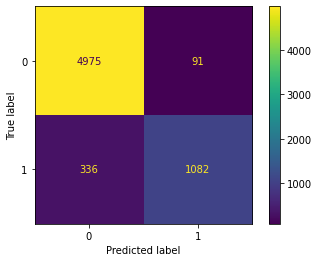

In [41]:
plot_confusion_matrix(be, X_test, y_test)

In [42]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5066
           1       0.92      0.76      0.84      1418

    accuracy                           0.93      6484
   macro avg       0.93      0.87      0.90      6484
weighted avg       0.93      0.93      0.93      6484



In [43]:
be.score(X_test, y_test)

0.9341455891425047

###### precision recall curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


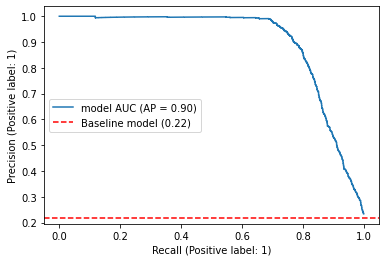

In [44]:
plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

###### learning curve

In [45]:
a, b, c = learning_curve(be, X, y, n_jobs=-1, scoring='accuracy')

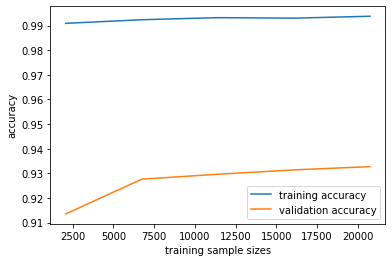

In [46]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()


### Part 2

##### Overfitting:

1. High training accuracy (--- low bias)
2. Low testing/ validation accuracy (--- high variance)
3. Big gap between training and validation curves (--- high variance)
4. Overfitting makes a very complex model and learns even the "noise" in the data, which is undesirable

Remedial measures:

1. Add more training samples, if possible, to allow the model to learn better


2. Working with data at hand:

    Make a simpler model / reduce complexity of model:
- try reducing number of features
- try increasing regularization (lambda)
- try pruning the decision trees

### Part 3 EXPLAINABLE AI (SHAP)

SHAP (Shapley Additive Explanations) is a method to explain individual predictions, based on the game theoretically optimal Shapley values.

In [47]:
#set the SHAP type
if selected_algo_name in ['RandomForestClassifier','GradientBoostingClassifier']:
  SHAP_TYPE=False  #tree based model
else:
  SHAP_TYPE=True

In [48]:
#for  tree based models
if SHAP_TYPE==False:
  import shap


  #set the tree explainer as the model of the pipeline
  explainer = shap.TreeExplainer(be['model'])

  #apply the preprocessing to x_test
  #returns an ndarray bacuse of columntransformer function. need to add column names
  observations = be['coltf'].transform(X_test)

  #find column names
  feature_col_names=be.named_steps['coltf'].transformers_[0][2]+be.named_steps['coltf'].transformers_[1][2]
  observations=pd.DataFrame(observations,columns=feature_col_names)

  #get Shap values from preprocessed data
  shap_values = explainer.shap_values(observations)



In [49]:
#for non tree based models
if SHAP_TYPE==False:
  import shap
  #load JS vis in the notebook
  shap.initjs() 
  indiv=1
  
  shap.force_plot(explainer.expected_value, shap_values[indiv,:], X_test.iloc[indiv,:])



In [50]:
#for  non tree based models
if SHAP_TYPE==True:
  import shap

  #find column names
  feature_col_names=be.named_steps['coltf'].transformers_[0][2]+be.named_steps['coltf'].transformers_[1][2]

  #set the explainer as the model of the pipeline
  explainer = shap.Explainer(be.predict,X,feature_names=feature_col_names)

  #apply the preprocessing to x_test
  #returns an ndarray bacuse of columntransformer function. need to add column names
  #observations = be['coltf'].transform(X_test)


  #observations=pd.DataFrame(observations,columns=feature_col_names)

  #get Shap values from preprocessed data
  shap_values = explainer(X_test)

  shap_values


The Force plot below gives us the explainability of a single model prediction. Force plot can be used for error analysis, finding the explanation to specific instance prediction.

In [51]:
#for  non tree based models
import shap
if SHAP_TYPE==True:
   
    #load JS vis in the notebook
    shap.initjs() 

    indiv=1
    shap.force_plot(shap_values[indiv,:], X_test.iloc[indiv,:])



you can see a comparison between feature importance calculated by SHAP values.Features with large absolute Shapley values are important.

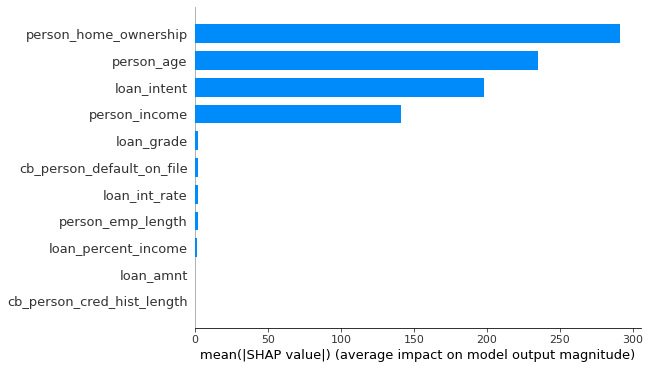

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The summary plot below combines feature importance with feature effects. Each point on the summary plot is a Shapley value of an instance per feature. 

In [53]:
X_test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
31162,44,80000,MORTGAGE,14.0,MEDICAL,A,10000,6.03,0.13,N,15
17831,24,38000,RENT,0.0,PERSONAL,B,12000,11.89,0.32,N,3
21226,33,113800,RENT,8.0,MEDICAL,B,5000,11.83,0.04,N,9
8789,22,60000,MORTGAGE,2.0,EDUCATION,B,3500,9.99,0.06,N,2
5717,23,38000,RENT,1.0,MEDICAL,A,5200,7.88,0.14,N,3
...,...,...,...,...,...,...,...,...,...,...,...
22219,32,53408,MORTGAGE,8.0,VENTURE,B,1400,10.99,0.03,N,6
8175,25,42000,RENT,0.0,EDUCATION,E,7400,16.32,0.18,N,4
29915,42,100000,RENT,3.0,VENTURE,D,10000,13.55,0.10,Y,13
480,24,18000,MORTGAGE,3.0,VENTURE,C,1200,11.34,0.07,Y,4



### Part 4 DECILE ANALYSIS

A decile is a quantitative method of splitting up a set of ranked data into 10 equally large subsections. A decile is usually used to assign decile ranks to a data set. A decile rank arranges the data in order from lowest to highest and is done on a scale of one to 10 where each successive number corresponds to an increase of 10 percentage points. 

In [54]:
# Model predictions are 0 (good loan) and 1 (bad loan) with a 0.5 cutoff. However, we need custom thresholds for further anaysis. lets get raw probabilities.
pred_probs=be.predict_proba(X_test)

In [55]:
pred_probs

array([[9.99999996e-01, 4.25464565e-09],
       [3.53520403e-06, 9.99996465e-01],
       [9.99390727e-01, 6.09272788e-04],
       ...,
       [9.99936316e-01, 6.36842488e-05],
       [9.99984563e-01, 1.54367818e-05],
       [9.40704095e-01, 5.92959050e-02]])

In [56]:
#save results
df_prediction_prob = pd.DataFrame(pred_probs, columns = ['prob_0_good', 'prob_1_bad'])
df_test_dataset = pd.DataFrame(X_test.values, columns = X_test.columns)
df_target = pd.DataFrame(y_test.values,columns= ['Actual Outcome'])
df_prediction_target = pd.DataFrame(preds,columns= ['Predicted Outcome'])

dfx=pd.concat([df_target,df_prediction_target, df_prediction_prob, df_test_dataset], axis=1)

dfx.to_csv(dir_path+"f4_NewApplications_CreditScore_Predictions.xlsx", sep=',', encoding='UTF-8')

dfx.head(10)

,Actual Outcome,Predicted Outcome,prob_0_good,prob_1_bad,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,0,1.000000,4.254646e-09,44,80000,MORTGAGE,14.0,MEDICAL,A,10000,6.03,0.13,N,15
1,1,1,0.000004,9.999965e-01,24,38000,RENT,0.0,PERSONAL,B,12000,11.89,0.32,N,3
2,0,0,0.999391,6.092728e-04,33,113800,RENT,8.0,MEDICAL,B,5000,11.83,0.04,N,9
3,0,0,0.999982,1.798008e-05,22,60000,MORTGAGE,2.0,EDUCATION,B,3500,9.99,0.06,N,2
4,0,0,0.999903,9.724947e-05,23,38000,RENT,1.0,MEDICAL,A,5200,7.88,0.14,N,3
5,0,0,0.927917,7.208281e-02,24,113000,MORTGAGE,5.0,EDUCATION,B,17950,11.99,0.16,N,4
6,0,0,0.992237,7.762558e-03,33,30000,MORTGAGE,1.0,DEBTCONSOLIDATION,C,4000,NaN,0.13,Y,7
7,0,0,0.999993,7.333093e-06,25,97440,RENT,9.0,EDUCATION,A,15000,7.49,0.15,N,4
8,0,0,0.999999,1.370230e-06,32,53000,RENT,4.0,MEDICAL,A,9000,5.79,0.17,N,6
9,0,0,0.999940,5.965358e-05,24,49344,MORTGAGE,6.0,DEBTCONSOLIDATION,B,8500,9.99,0.17,N,4


In [57]:
dfd=dfx[['Actual Outcome','prob_0_good','prob_1_bad','Predicted Outcome']]

dfd=dfd.sort_values(by=['prob_0_good'],ascending=False)

dfd.head()

,Actual Outcome,prob_0_good,prob_1_bad,Predicted Outcome
5337,0,1.0,8.815272e-34,0
6297,0,1.0,8.359834e-175,0
4368,0,1.0,1.162753e-12,0
5926,0,1.0,1.168999e-12,0
5938,0,1.0,3.603463e-12,0


In [58]:
#calculate decile of each value in data frame. 10 Quantile-based bins.
dfd['Decile'],deciles = pd.qcut(dfd['prob_0_good'],10,retbins=True,labels=[10,9,8,7,6,5,4,3,2,1])
dfd.head(10)
print(deciles)

[0.00000000e+00 1.07508114e-05 8.43028505e-01 9.96545879e-01
 9.99410510e-01 9.99848191e-01 9.99956998e-01 9.99987035e-01
 9.99997195e-01 9.99999710e-01 1.00000000e+00]


In [59]:
dfd

,Actual Outcome,prob_0_good,prob_1_bad,Predicted Outcome,Decile
5337,0,1.0,8.815272e-34,0,1
6297,0,1.0,8.359834e-175,0,1
4368,0,1.0,1.162753e-12,0,1
5926,0,1.0,1.168999e-12,0,1
5938,0,1.0,3.603463e-12,0,1
...,...,...,...,...,...
3769,1,0.0,1.000000e+00,1,10
3760,1,0.0,1.000000e+00,1,10
6384,1,0.0,1.000000e+00,1,10
5758,1,0.0,1.000000e+00,1,10


In [60]:
pd.pivot_table(dfd, values=['Actual Outcome','prob_0_good'], columns=['Decile'],
          aggfunc={'Actual Outcome':np.sum,'prob_0_good':np.min}).transpose().iloc[::-1]

,Actual Outcome,prob_0_good
Decile,,
1,4.0,1.000000
2,9.0,0.999997
3,16.0,0.999987
4,26.0,0.999957
5,36.0,0.999848
6,34.0,0.999411
7,65.0,0.996546
8,99.0,0.844492
9,482.0,0.000011


##Construct decile analysis table

In [61]:
t1=pd.DataFrame(dfd['Decile'].value_counts().sort_index(ascending=False))
t2=pd.pivot_table(dfd, values=['Actual Outcome','prob_0_good'], index=['Decile'],
          aggfunc={'Actual Outcome':np.sum,'prob_0_good':np.min}).iloc[::-1]

t3=pd.concat([t1,t2],axis=1)
t3.columns=['Count of Decile','Sum of Actual Outcome 1_bad','MIN of prob_0_good']

dfd_pivot=t3
dfd_pivot.index.name="Decile"

dfd_pivot['Count of 0_good']=dfd_pivot['Count of Decile']-dfd_pivot['Sum of Actual Outcome 1_bad']
dfd_pivot['Cum of 0_good']=dfd_pivot['Count of 0_good'].cumsum()

dfd_pivot['Count of 1_bad']=dfd_pivot['Sum of Actual Outcome 1_bad']
dfd_pivot['Cum of 1_bad']=dfd_pivot['Count of 1_bad'].cumsum()

dfd_pivot['%Cum of 0_good']=dfd_pivot['Cum of 0_good']/dfd_pivot['Cum of 0_good'][-1]*100
#dfd_pivot['%Cum of 0_good'] = dfd_pivot['%Cum of 0_good'].map('%{:,.2f}'.format)
dfd_pivot['%Cum of 1_bad']=dfd_pivot['Cum of 1_bad']/dfd_pivot['Cum of 1_bad'][-1]*100

dfd_pivot['%Cum of 1_bad AVOIDED']=100-dfd_pivot['%Cum of 1_bad']



#from IPython.display import display
#df_style = dfd_pivot.style.format({'%Cum of 0_good': '{:,.2%}'})
#display(df_style)

dfd_pivot

,Count of Decile,Sum of Actual Outcome 1_bad,MIN of prob_0_good,Count of 0_good,Cum of 0_good,Count of 1_bad,Cum of 1_bad,%Cum of 0_good,%Cum of 1_bad,%Cum of 1_bad AVOIDED
Decile,,,,,,,,,,
1,649,4,1.000000,645,645,4,4,12.731938,0.282087,99.717913
2,648,9,0.999997,639,1284,9,13,25.345440,0.916784,99.083216
3,648,16,0.999987,632,1916,16,29,37.820766,2.045134,97.954866
4,649,26,0.999957,623,2539,26,55,50.118437,3.878702,96.121298
5,648,36,0.999848,612,3151,36,91,62.198974,6.417489,93.582511
6,648,34,0.999411,614,3765,34,125,74.318989,8.815233,91.184767
7,649,65,0.996546,584,4349,65,190,85.846822,13.399154,86.600846
8,648,99,0.844492,549,4898,99,289,96.683774,20.380818,79.619182
9,648,482,0.000011,166,5064,482,771,99.960521,54.372355,45.627645


##Credit Risk Assumption Table

In [62]:
pd_risk_assumptions=pd.DataFrame(pd.Series({'Loss from a bad loan (Target = 1)':600,'Profit from a good loan (Target = 0)':100},name='Loss/Profit per individual credit'))
pd_risk_assumptions.index.name="Assumptions"

In [63]:
pd_risk_assumptions

,Loss/Profit per individual credit
Assumptions,
Loss from a bad loan (Target = 1),600
Profit from a good loan (Target = 0),100


In [64]:
dfd_pivot['profit to business']=dfd_pivot['Cum of 0_good']*pd_risk_assumptions.loc['Profit from a good loan (Target = 0)','Loss/Profit per individual credit'] - \
                                dfd_pivot['Cum of 1_bad']*pd_risk_assumptions.loc['Loss from a bad loan (Target = 1)','Loss/Profit per individual credit']

In [65]:
dfd_pivot

,Count of Decile,Sum of Actual Outcome 1_bad,MIN of prob_0_good,Count of 0_good,Cum of 0_good,Count of 1_bad,Cum of 1_bad,%Cum of 0_good,%Cum of 1_bad,%Cum of 1_bad AVOIDED,profit to business
Decile,,,,,,,,,,,
1,649,4,1.000000,645,645,4,4,12.731938,0.282087,99.717913,62100
2,648,9,0.999997,639,1284,9,13,25.345440,0.916784,99.083216,120600
3,648,16,0.999987,632,1916,16,29,37.820766,2.045134,97.954866,174200
4,649,26,0.999957,623,2539,26,55,50.118437,3.878702,96.121298,220900
5,648,36,0.999848,612,3151,36,91,62.198974,6.417489,93.582511,260500
6,648,34,0.999411,614,3765,34,125,74.318989,8.815233,91.184767,301500
7,649,65,0.996546,584,4349,65,190,85.846822,13.399154,86.600846,320900
8,648,99,0.844492,549,4898,99,289,96.683774,20.380818,79.619182,316400
9,648,482,0.000011,166,5064,482,771,99.960521,54.372355,45.627645,43800


In [66]:
decile_index_max=dfd_pivot['profit to business'].idxmax()
loss_profit_max=dfd_pivot['profit to business'].max()
cuttoff_prob_0_good=dfd_pivot.loc[decile_index_max,'MIN of prob_0_good']

In [67]:
decile=dfd_pivot['profit to business'].idxmax()

pd_final_recommendations_1=pd.DataFrame(pd.Series({'Approve Loan Application, if Probability for Target = 0 is higher than':cuttoff_prob_0_good},name='MIN of prob_0_good'))
pd_final_recommendations_1.index.name="Final Recommendation: Keeping Only Profitability in Mind"
pd_final_recommendations_1['Decile Bin']=decile_index_max
pd_final_recommendations_1['Loss/Profit']=loss_profit_max


for market expansion busines objective, we need to capture more customers even if the percentage of bad customers increases. in loss of a little profit.

so a decile one below maximun profit decile would be suggested for this pusposes

In [68]:
decile_index=decile_index_max+1
loss_profit=dfd_pivot.loc[decile_index,'profit to business']
cuttoff_prob_0_good=dfd_pivot.loc[decile_index,'MIN of prob_0_good']


In [69]:
pd_final_recommendations_2=pd.DataFrame(pd.Series({'Approve Loan Application, if Probability for Target = 0 is higher than':cuttoff_prob_0_good},name='MIN of prob_0_good'))
pd_final_recommendations_2.index.name="Final Recommendation: Keeping Profitability & Expansion in Mind"
pd_final_recommendations_2['Decile Bin']=decile_index
pd_final_recommendations_2['Loss/Profit']=loss_profit


ANALYSIS RESULTS

In [70]:
pd_final_recommendations_1

,MIN of prob_0_good,Decile Bin,Loss/Profit
Final Recommendation: Keeping Only Profitability in Mind,,,
"Approve Loan Application, if Probability for Target = 0 is higher than",0.996546,7,320900


This means that when the model prediction probability cut off is set to 0.9965462, a percentage of 85.8 of good customers are covered with the  expense of 13.4% of bad customers. The profit is maximized. 86.6% of bad customers avoided

In [71]:
pd_final_recommendations_2

,MIN of prob_0_good,Decile Bin,Loss/Profit
Final Recommendation: Keeping Profitability & Expansion in Mind,,,
"Approve Loan Application, if Probability for Target = 0 is higher than",0.844492,8,316400


This means that when the model prediction probability cut off is set to 0.844492, a percentage of 96.7 of good customers are covered with the  expense of 20.4% of bad customers. The profit is below the maximized value. On the other hand, customer coverage is incresed.